# REGRESSION WITH NEURAL NETWORKS

The goal of a regression analysis is to estimate the relationship between *dependent variables* and  *independent variables*.

Given a set of observed data points $X = {x_0, x_1, ..., x_n}$ with corresponding output values $Y = { y_0, y_1, ..., y_n}$, we want to relate Y to X through a *function* $y = f(x, \omega)$, where $\omega$ are parameters of the model to be determined by the analysis.

Up to now, we have worked with a series of basis functions that are linear in the parameters of the model. The natural upgrade is to consider non linear functions in the parameters. The way in which we implement this in neural networks is by composing many linear functions together in a non linear way:

$$
f(x,\underline\omega) = \sum_{i=0}^M \omega_i \, h_i(x,\underline\theta)
$$

where $h_i = a [ \theta_{i0} + \theta_{i1}x]$ and $a$ is a so-called activation function. While different choices can be made as activation function, for the time being we focus on a popular choice, the ReLu function:

$$
a [z] = \left\{ 
    \begin{array}{lr}
    0 & z<0\\
    z & z \ge 0
    \end{array}\right.
$$



Depending on how many linear piecewise function we have (parameter M), the network is able to approximate very complicated functions. The drawback is that we loose interpretation of the fitting functions.

## Generate Dataset

In [1]:
import sys
sys.path.append('../../supplemental_material')

import numpy as np
import matplotlib.pyplot as plt
import synth_dataset as sd
import matplotlib.colors as mcolors

# Define color-blind-friendly palette
hex1 = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']
hex1_inverted = hex1[::-1]
colors1=[mcolors.to_rgb(i) for i in hex1]

In [2]:
# array of x values
x = np.linspace(0,1,500)
# produce the two gaussian peak signals
signal = sd.random_peaks(x,peaks_range=[1,2],c = 0.10, roi_position=[0.45,0.55],ph_min = 0.1, ph_max = 0.5, edge_tol=0.2,method=2)
# produce an exponential background 
background = sd.exponential_bg(len(x))
# produce threshold jump
threshold = sd.random_arctan_curve(len(x),itx_min=0.1,center_min=0.45,center_max=0.55,x_scale_min=0.05, x_scale_max=0.1)


In [3]:
# add random noise to generate the raw signal
snr = 50
raw = sd.add_noise(snr=snr, signal = signal + background + threshold)


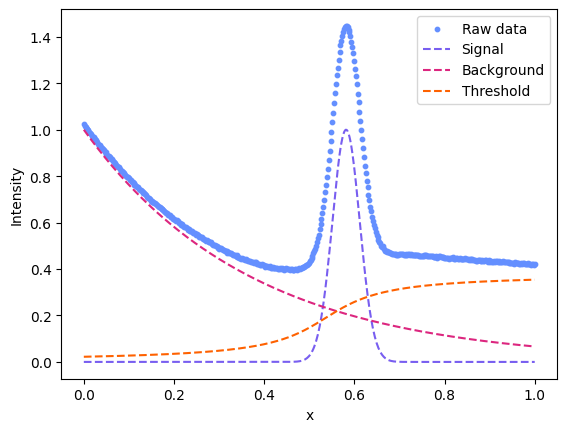

In [4]:
# plot the data
plt.scatter(x,raw,label='Raw data',color=colors1[0],s=10)
plt.plot(x,signal,label='Signal',ls='--',color=colors1[1])
plt.plot(x,background,label='Background',ls='--',color=colors1[2])
plt.plot(x,threshold,label='Threshold',ls='--',color=colors1[3])
plt.xlabel('x')
plt.ylabel('Intensity')
plt.legend()
plt.show()

## Build Neural Network

### Load PyTorch

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader

### Preparation of Training, Test and Validation sets

In [6]:
# Set random seed for reproducibility
np.random.seed(42)

# Shuffle the indices
indices = np.random.permutation(len(raw))

# Split the indices for training, testing, and validation sets
train_indices = indices[:3 * len(raw) // 4]
test_indices = indices[3 * len(raw) // 4:]

# Create the training, testing, and validation sets
raw_training = raw[train_indices]
raw_testing = raw[test_indices]

### Define a model

In [7]:
# Define the model architecture using a sequential container

# define input size, hidden layer size, output size 
D_i, D_k, D_o = 1, 100, 1

# The model consists of:
# - A linear layer that maps from 1 input feature to N hidden units
# - A ReLU activation function
# - A linear layer that maps from  N hidden units to 1 output feature
model = nn.Sequential(
    nn.Linear(D_i, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_k),
    nn.ReLU(),
    # nn.Linear(D_k, D_k),
    # nn.ReLU(),
    # nn.Linear(D_k, D_k),
    # nn.ReLU(),
    nn.Linear(D_k, D_o)
)

In [8]:
# Convert the training, validation, and testing data to PyTorch tensors
# `unsqueeze(1)` adds an extra dimension to the tensor, making it a column vector
input_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(D_i)
raw_training_tensor = torch.tensor(raw_training, dtype=torch.float32).unsqueeze(D_o)
raw_testing_tensor = torch.tensor(raw_testing, dtype=torch.float32).unsqueeze(D_o)

### Define Loss Function

In [9]:
# Define the loss function and optimizer
# Mean Squared Error (MSE) is used as the loss function
criterion = nn.MSELoss()

### Optimizer

In [10]:
# Adam optimizer is used with weight decay (L2 regularization) to prevent overfitting
optimizer = optim.SGD(model.parameters(), lr=0.1,momentum=0.9)
# object that decreases learning rate by half every N epochs 
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

### Training

In [11]:

# Train the model
num_epochs = 1000  # Number of epochs to train the model
losses = []  # List to store the loss value for each epoch
# load data
data_loader = DataLoader(TensorDataset(input_tensor[train_indices],raw_training_tensor), batch_size=48, shuffle=True)
# Iterate over the epochs
for epoch in range(num_epochs):
    epoch_loss = 0.0  # Initialize the loss value for this epoch
    # Iterate over the training data in batches
    for i, data in enumerate(data_loader):
        # Get the inputs and targets from the data loader
        inputs, targets = data
        # Clear the gradients of all optimized tensors
        optimizer.zero_grad()  
        
        # Forward pass: compute the model output
        outputs = model(inputs)
        # Compute the loss between the model output and the actual targets
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()        # Compute the gradient of the loss with respect to model parameters
        optimizer.step()       # Update the model parameters based on the computed gradients
        
        # Store the loss value for this epoch
        epoch_loss += loss.item()
        losses.append(loss.item())  # Store the loss value for this epoch
    print(f'Epoch {epoch:5d}, loss {epoch_loss:.3f}')
    # tell scheduler to consider updating learning rate 
    scheduler.step()

Epoch     0, loss 1.401
Epoch     1, loss 0.721
Epoch     2, loss 0.528
Epoch     3, loss 0.469
Epoch     4, loss 0.444
Epoch     5, loss 0.465
Epoch     6, loss 0.470
Epoch     7, loss 0.436
Epoch     8, loss 0.470
Epoch     9, loss 0.470
Epoch    10, loss 0.450
Epoch    11, loss 0.441
Epoch    12, loss 0.432
Epoch    13, loss 0.456
Epoch    14, loss 0.456
Epoch    15, loss 0.418
Epoch    16, loss 0.420
Epoch    17, loss 0.421
Epoch    18, loss 0.427
Epoch    19, loss 0.420
Epoch    20, loss 0.417
Epoch    21, loss 0.426
Epoch    22, loss 0.407
Epoch    23, loss 0.396
Epoch    24, loss 0.401
Epoch    25, loss 0.404
Epoch    26, loss 0.399
Epoch    27, loss 0.400
Epoch    28, loss 0.406
Epoch    29, loss 0.432
Epoch    30, loss 0.423
Epoch    31, loss 0.400
Epoch    32, loss 0.396
Epoch    33, loss 0.392
Epoch    34, loss 0.398
Epoch    35, loss 0.398
Epoch    36, loss 0.393
Epoch    37, loss 0.391
Epoch    38, loss 0.388
Epoch    39, loss 0.398
Epoch    40, loss 0.385
Epoch    41, los

### Performance Evaluation

The parameters that influence performance are

- Signal-To-Noise Ratio (`snr` variable)   [noise]
- Amount of training data (`len(x)` variable) [variance]
- Choice of model [bias]

For scientific applications, it is frequently hard to improve on the first two.

In [12]:

# Evaluate the model on the test set
# Forward pass: compute the model output for the test set
outputs_train = model(input_tensor[train_indices])
outputs_test = model(input_tensor[test_indices])
# Compute the loss between the model output and the actual test targets
loss = criterion(outputs_test, raw_testing_tensor)
print('Test Loss:', loss.item())  # Print the test loss

Test Loss: 0.02512936107814312


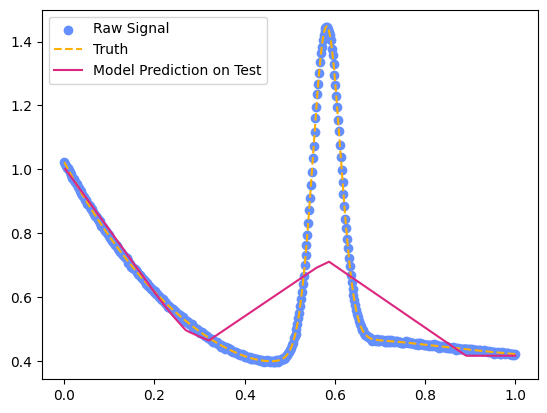

In [13]:
# reorder the data for plotting
order_train=x[train_indices].argsort()
order_test=x[test_indices].argsort()
plt.scatter(x,raw, label='Raw Signal', color=colors1[0])
plt.plot(x,signal+background+threshold, label='Truth', ls='--', color=colors1[4])
#plt.plot(x[train_indices][order_train],outputs_train.detach().numpy()[order_train], label='Model Prediction on Training', color=colors1[3])
plt.plot(x[test_indices][order_test],outputs_test.detach().numpy()[order_test], label='Model Prediction on Test', color=colors1[2])
plt.legend()

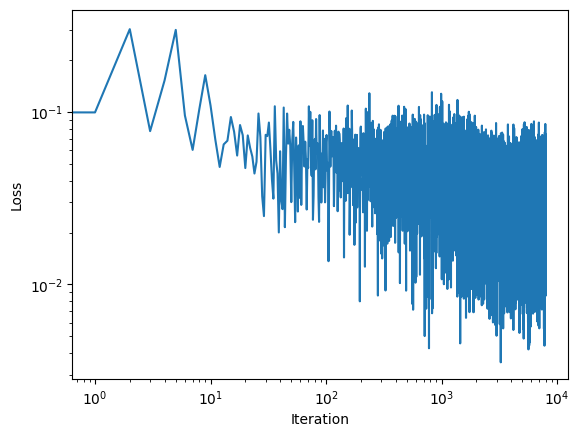

In [14]:
plt.plot(losses)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [15]:
epoch_loss

0.26116952020674944